In [ ]:
# Install missing dependencies for Tarsier2-Recap-7b (Qwen2-VL backbone)
# %pip install -q qwen-vl-utils

# Install missing dependencies for FaceScanPaliGemma_Emotion
# %pip install -q transformers>=4.42.0 Pillow opencv-python


In [1]:
import os
import torch
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

BASE_DIR = Path("/mnt/Work/ML/Code/EmoRecVid")
MANIFEST_PATH = BASE_DIR / "utterance_clips" / "manifest.csv"

print("Imports OK")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


2026-02-28 20:37:45.711156: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-28 20:37:45.933841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Imports OK
CUDA available: True
GPU: NVIDIA GeForce RTX 3060
VRAM: 12.5 GB


In [ ]:
MODEL_ID = "omni-research/Tarsier2-Recap-7b"

print(f"Loading model: {MODEL_ID}")
model = Qwen2VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    # local_files_only=True,
    # attn_implementation="flash_attention_2",   # remove if flash-attn not installed
)
model.eval()

processor = AutoProcessor.from_pretrained(MODEL_ID, local_files_only=True)

print("Model loaded successfully")
print(f"Model device map: {model.hf_device_map}")


`torch_dtype` is deprecated! Use `dtype` instead!


Loading model: omni-research/Tarsier2-Recap-7b


In [ ]:

def analyze_clip(video_path: str, max_new_tokens: int = 512, fps: float = 2.0) -> str:
    """
    Run VidEmo-3B on a single utterance video clip and return a detailed
    behavioral analysis (facial expressions, body language, behavioral cues).
    """
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "video",
                    "video": video_path,
                    "fps": fps,
                    "max_pixels": 360 * 420,
                },
                {
                    "type": "text",
                    "text": (
                        "Watch this short video clip of a person speaking. Focus exclusively on visible emotional cues — ignore clothing, background, and any irrelevant details.\n"
                        "Provide a concise analysis covering:\n"
                        "1. **Facial Expressions**: Describe specific muscle movements and micro-expressions (e.g., brow furrowing, lip tension, eye widening, jaw clenching, cheek raising).\n"
                        "2. **Head & Gaze**: Note head tilts, nods, shakes, and where the eyes are directed.\n"
                        "3. **Body Language**: Describe visible posture shifts, gestures, and tension or relaxation in the body.\n"
                        "4. **Dominant Emotion**: State the most likely emotion(s) being expressed and the specific visual cues that support this conclusion.\n"
                        "Be precise and ground every observation in a visible emotional signal."
                    ),
                },
            ],
        }
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs, video_kwargs = process_vision_info(messages, return_video_kwargs=True)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
        **video_kwargs,
    ).to(model.device)

    with torch.inference_mode():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
        )

    generated_ids_trimmed = [
        out_ids[len(in_ids):]
        for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    response = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0].strip()

    return response

print("analyze_clip() ready")


analyze_clip() ready


In [ ]:

# Load manifest – preserve any already-completed analyses
manifest = pd.read_csv(MANIFEST_PATH)

total  = len(manifest)
done_before = manifest["vlm_analysis"].notna().sum()
print(f"Total clips : {total}")
print(f"Already done: {done_before}  |  Remaining: {total - done_before}")

# ── Batch inference helper ────────────────────────────────────────────
BATCH_SIZE = 8      # increase for throughput (reduce if OOM)
SAVE_EVERY = 20     # checkpoint to disk every N clips
FPS        = 1.0    # frames-per-second fed to the model (fewer frames = faster)

PROMPT_TEXT = (
    "Watch this short video clip of a person speaking. Focus exclusively on visible emotional cues — ignore clothing, background, and any irrelevant details.\n"
    "Provide a concise analysis covering:\n"
    "1. **Facial Expressions**: Describe specific muscle movements and micro-expressions (e.g., brow furrowing, lip tension, eye widening, jaw clenching, cheek raising).\n"
    "2. **Head & Gaze**: Note head tilts, nods, shakes, and where the eyes are directed.\n"
    "3. **Body Language**: Describe visible posture shifts, gestures, and tension or relaxation in the body.\n"
    "4. **Dominant Emotion**: State the most likely emotion(s) being expressed and the specific visual cues that support this conclusion.\n"
    "Be precise and ground every observation in a visible emotional signal."
)


def analyze_batch(video_paths: list[str], max_new_tokens: int = 256, fps: float = FPS) -> list[str]:
    """Run the VLM on a batch of video clips and return one response per clip."""
    all_messages = [
        [
            {
                "role": "user",
                "content": [
                    {"type": "video", "video": vp, "fps": fps, "max_pixels": 360 * 420},
                    {"type": "text", "text": PROMPT_TEXT},
                ],
            }
        ]
        for vp in video_paths
    ]

    texts = [
        processor.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
        for msgs in all_messages
    ]

    image_inputs, video_inputs, video_kwargs = process_vision_info(
        all_messages, return_video_kwargs=True
    )

    inputs = processor(
        text=texts,
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
        **video_kwargs,
    ).to(model.device)

    with torch.inference_mode():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
        )

    generated_ids_trimmed = [
        out_ids[len(in_ids):]
        for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    responses = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return [r.strip() for r in responses]


# ── Main loop ─────────────────────────────────────────────────────────
# Only process rows that have not been analysed yet (NaN) or previously errored
pending = list(manifest[manifest["vlm_analysis"].isna()].index)
print(f"Queued for processing: {len(pending)} clips\n")

processed = 0

with tqdm(total=len(pending), desc="VLM analysis") as pbar:
    for batch_start in range(0, len(pending), BATCH_SIZE):
        batch_idx = pending[batch_start : batch_start + BATCH_SIZE]
        batch_rows = manifest.loc[batch_idx]

        video_paths = [str(BASE_DIR / row["path"]) for _, row in batch_rows.iterrows()]

        try:
            results = analyze_batch(video_paths)
            for idx, analysis in zip(batch_idx, results):
                manifest.at[idx, "vlm_analysis"] = analysis
        except Exception as e:
            for idx in batch_idx:
                manifest.at[idx, "vlm_analysis"] = f"ERROR: {e}"
            print(f"\nError on batch {batch_idx}: {e}")

        processed += len(batch_idx)
        pbar.update(len(batch_idx))

        # Periodic checkpoint
        if processed % SAVE_EVERY == 0:
            manifest.to_csv(MANIFEST_PATH, index=False)

# Final save
manifest.to_csv(MANIFEST_PATH, index=False)

done   = manifest["vlm_analysis"].notna().sum()
errors = manifest["vlm_analysis"].str.startswith("ERROR:", na=False).sum()
print(f"\nDone. {done}/{total} clips processed, {errors} errors.")
print(f"Results saved → {MANIFEST_PATH}")
manifest.head(3)


Total clips : 10039
Already done: 9937  |  Remaining: 102
Queued for processing: 102 clips



VLM analysis:   0%|          | 0/102 [00:00<?, ?it/s]

/mnt/Work/Environments/Ubuntu/Conda/envs/kaggle/lib/python3.12/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/mnt/Work/Environments/Ubuntu/Conda/envs/kaggle/lib/python3.12/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of


Done. 10039/10039 clips processed, 0 errors.
Results saved → /mnt/Work/ML/Code/EmoRecVid/utterance_clips/manifest.csv


,utterance_id,emotion,speaker_gender,crop_side,start,end,path,vlm_analysis
0,Ses01F_impro01_F000,neu,F,left,6.2901,8.2357,utterance_clips/Session1/Ses01F_impro01/Ses01F...,The video features a young adult woman with da...
1,Ses01F_impro01_F001,neu,F,left,10.0100,11.3925,utterance_clips/Session1/Ses01F_impro01/Ses01F...,The video features a young adult woman with da...
2,Ses01F_impro01_F002,neu,F,left,14.8872,18.0175,utterance_clips/Session1/Ses01F_impro01/Ses01F...,The video features a young adult female with s...


In [ ]:

# ── Retry empty / errored clips ───────────────────────────────────────
manifest = pd.read_csv(MANIFEST_PATH)

is_error = manifest["vlm_analysis"].str.startswith("ERROR:", na=False)
is_empty = manifest["vlm_analysis"].isna()
retry_mask = is_error | is_empty

retry_idx = list(manifest[retry_mask].index)
print(f"Empty  : {is_empty.sum()}")
print(f"Errored: {is_error.sum()}")
print(f"Total to retry: {len(retry_idx)}")

processed = 0

with tqdm(total=len(retry_idx), desc="Retry VLM analysis") as pbar:
    for batch_start in range(0, len(retry_idx), BATCH_SIZE):
        batch_idx = retry_idx[batch_start : batch_start + BATCH_SIZE]
        batch_rows = manifest.loc[batch_idx]

        video_paths = [str(BASE_DIR / row["path"]) for _, row in batch_rows.iterrows()]

        try:
            results = analyze_batch(video_paths)
            for idx, analysis in zip(batch_idx, results):
                manifest.at[idx, "vlm_analysis"] = analysis
        except Exception as e:
            for idx in batch_idx:
                manifest.at[idx, "vlm_analysis"] = f"ERROR: {e}"
            print(f"\nError on batch {batch_idx}: {e}")

        processed += len(batch_idx)
        pbar.update(len(batch_idx))

        if processed % SAVE_EVERY == 0:
            manifest.to_csv(MANIFEST_PATH, index=False)

# Final save
manifest.to_csv(MANIFEST_PATH, index=False)

total   = len(manifest)
done    = manifest["vlm_analysis"].notna().sum()
errors  = manifest["vlm_analysis"].str.startswith("ERROR:", na=False).sum()
print(f"\nDone. {done}/{total} clips processed, {errors} errors remaining.")
print(f"Results saved → {MANIFEST_PATH}")
manifest[retry_mask].head(3)


Empty  : 0
Errored: 0
Total to retry: 0


Retry VLM analysis: 0it [00:00, ?it/s]


Done. 10039/10039 clips processed, 0 errors remaining.
Results saved → /mnt/Work/ML/Code/EmoRecVid/utterance_clips/manifest.csv


,utterance_id,emotion,speaker_gender,crop_side,start,end,path,vlm_analysis


In [ ]:
# analyze_clip("utterance_clips/Session1/Ses01F_impro06/Ses01F_impro06_F006.avi", max_new_tokens=512, fps=1.0)

qwen-vl-utils using torchvision to read video.
/mnt/Work/Environments/Ubuntu/Conda/envs/kaggle/lib/python3.12/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


"The video features a young adult woman with shoulder-length dark brown hair styled in a low ponytail, sitting against a plain off-white wall. She wears a black headband adorned with a small white flower and a dark bracelet on her left wrist. Her face is round, with a rounded chin and narrow lips. Initially, she appears pensive or neutral, with her gaze directed downwards towards her lap. Her mouth corners are slightly downturned, and her eyebrows remain neutral. She fidgets with her hands, suggesting a degree of restlessness or preoccupation. As she begins to speak, her mouth moves, and her teeth become briefly visible. Her gaze shifts upwards momentarily before returning to its downward position. Her expression remains largely unchanged, though there's a subtle shift towards a more neutral demeanor as she continues talking. Her head remains relatively still throughout, with only slight tilts and nods accompanying her speech. The lighting is dim, casting subtle shadows on her face, pa

In [ ]:

# # ── FaceScanPaliGemma_Emotion ─────────────────────────────────────────
# # Fine-tuned PaliGemma-3B on AffectNet; classifies a face image into one of:
# #   neutral | happy | sad | surprise | fear | disgust | anger | contempt
# # Model card: https://huggingface.co/NYUAD-ComNets/FaceScanPaliGemma_Emotion

# import os
# # Disable the xet/CAS backend so HF falls back to standard HTTP downloads
# os.environ["HF_HUB_DISABLE_XET_BACKEND"] = "1"

# import torch
# import pandas as pd
# import cv2
# import numpy as np
# from pathlib import Path
# from PIL import Image
# from tqdm.auto import tqdm
# from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
# from collections import Counter

# BASE_DIR = Path("/mnt/Work/ML/Code/EmoRecVid")
# MANIFEST_PATH = BASE_DIR / "utterance_clips" / "manifest.csv"

# PG_MODEL_ID = "NYUAD-ComNets/FaceScanPaliGemma_Emotion"
# PG_PROC_ID  = "google/paligemma-3b-pt-224"
# PG_PROMPT   = "what is the emotion of the person in the image?"

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Device: {device}")

# print(f"Loading processor from {PG_PROC_ID} …")
# pg_processor = PaliGemmaProcessor.from_pretrained(PG_PROC_ID)

# print(f"Loading model from {PG_MODEL_ID} …")
# pg_model = PaliGemmaForConditionalGeneration.from_pretrained(
#     PG_MODEL_ID,
#     torch_dtype=torch.bfloat16,
# )
# pg_model.to(device)
# pg_model.eval()
# print("PaliGemma emotion model loaded.")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Device: cuda
Loading processor from google/paligemma-3b-pt-224 …


`torch_dtype` is deprecated! Use `dtype` instead!


Loading model from NYUAD-ComNets/FaceScanPaliGemma_Emotion …


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

PaliGemma emotion model loaded.


In [ ]:

# VALID_EMOTIONS = {"neutral", "happy", "sad", "surprise", "fear", "disgust", "anger", "contempt"}

# def extract_frames(video_path: str, n_frames: int = 5) -> list[Image.Image]:
#     """Extract `n_frames` evenly-spaced frames from a video file as PIL images."""
#     cap = cv2.VideoCapture(video_path)
#     total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     if total == 0:
#         cap.release()
#         return []
#     indices = np.linspace(0, total - 1, min(n_frames, total), dtype=int)
#     frames = []
#     for idx in indices:
#         cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
#         ret, frame = cap.read()
#         if ret:
#             frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             frames.append(Image.fromarray(frame_rgb))
#     cap.release()
#     return frames


# # PaliGemma requires the <image> token at the start of the prompt
# _PG_PROMPT_WITH_TOKEN = "<image> " + PG_PROMPT

# def predict_emotion_video(video_path: str, n_frames: int = 5) -> str:
#     """
#     Extract frames, run PaliGemma on each frame, and return the per-frame
#     emotion labels as a space-separated string, e.g.:
#         "neutral happy neutral sad neutral"
#     Labels that fall outside VALID_EMOTIONS are included as-is so no
#     information is lost.
#     Returns "ERROR: no frames" if the video has no readable frames.
#     """
#     frames = extract_frames(video_path, n_frames=n_frames)
#     if not frames:
#         return "ERROR: no frames"

#     per_frame_labels = []

#     for frame in frames:
#         inputs = pg_processor(
#             text=_PG_PROMPT_WITH_TOKEN,
#             images=frame,
#             padding="longest",
#             do_convert_rgb=True,
#             return_tensors="pt",
#         ).to(device)
#         inputs = inputs.to(dtype=pg_model.dtype)

#         with torch.no_grad():
#             output = pg_model.generate(**inputs, max_length=500)

#         # Trim input tokens, decode only newly generated tokens
#         new_tokens = output[0][inputs.input_ids.shape[1]:]
#         decoded = pg_processor.decode(new_tokens, skip_special_tokens=True).strip().lower()

#         # First word as the label candidate
#         label = decoded.split()[0] if decoded.split() else "unknown"
#         per_frame_labels.append(label)

#     return " ".join(per_frame_labels)


# print("predict_emotion_video() ready  (returns space-separated per-frame labels)")
# print(f"Prompt: {_PG_PROMPT_WITH_TOKEN!r}")
# print(f"Extracts 5 frames per clip – one label per frame, all stored.")


predict_emotion_video() ready  (returns space-separated per-frame labels)
Prompt: '<image> what is the emotion of the person in the image?'
Extracts 5 frames per clip – one label per frame, all stored.


Utterance : Ses05M_script03_2_M028
GT emotion: ang
Video path: /mnt/Work/ML/Code/EmoRecVid/utterance_clips/Session5/Ses05M_script03_2/Ses05M_script03_2_M028.avi

Per-frame labels : ['neutral', 'surprise', 'neutral', 'surprise', 'neutral']
Valid labels     : ['neutral', 'surprise', 'neutral', 'surprise', 'neutral']
Dominant         : neutral


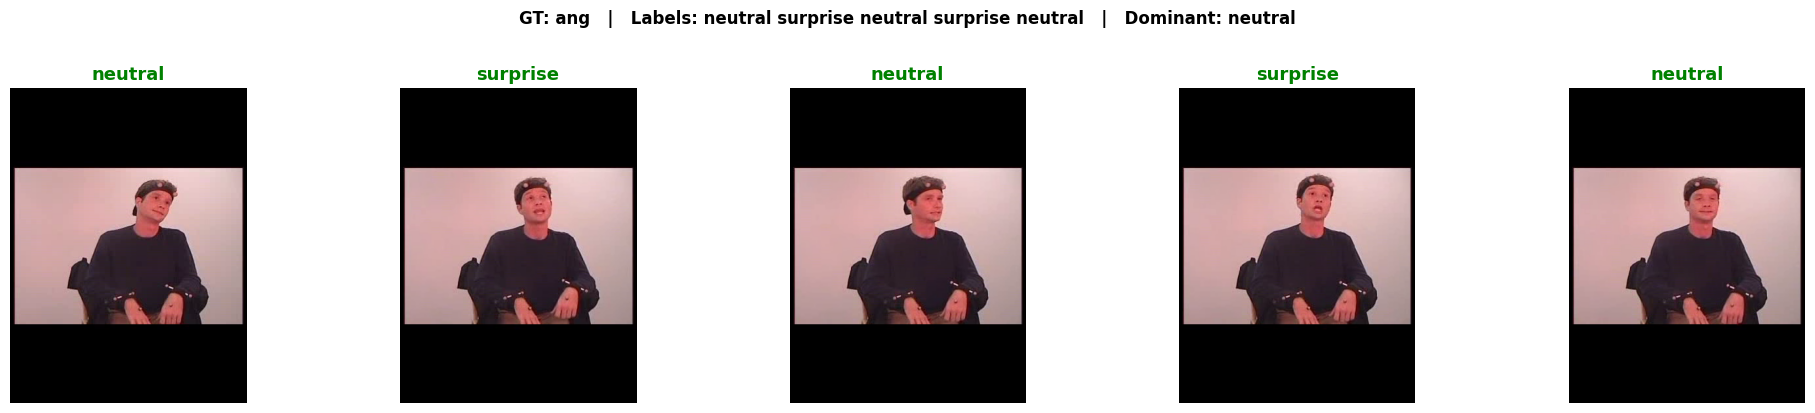

In [ ]:

# # ── Quick sanity-check: sample a random clip and visualise predictions ─
# import matplotlib.pyplot as plt
# from IPython.display import display

# manifest_preview = pd.read_csv(MANIFEST_PATH)

# # Pick a random row
# sample_row = manifest_preview.sample(1).iloc[0]
# sample_path = str(BASE_DIR / sample_row["path"])

# print(f"Utterance : {sample_row['utterance_id']}")
# print(f"GT emotion: {sample_row['emotion']}")
# print(f"Video path: {sample_path}")
# print()

# # Run through predict_emotion_video – returns "label1 label2 label3 ..."
# result_str = predict_emotion_video(sample_path, n_frames=5)
# per_frame_labels = result_str.split()
# valid = [l for l in per_frame_labels if l in VALID_EMOTIONS]

# print(f"Per-frame labels : {per_frame_labels}")
# print(f"Valid labels     : {valid}")
# print(f"Dominant         : {Counter(valid).most_common(1)[0][0] if valid else 'none'}")

# # Plot frames with their labels
# frames = extract_frames(sample_path, n_frames=5)
# n = len(frames)
# fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
# if n == 1:
#     axes = [axes]

# for ax, frame, lbl in zip(axes, frames, per_frame_labels):
#     ax.imshow(frame)
#     color = "green" if lbl in VALID_EMOTIONS else "red"
#     ax.set_title(lbl, fontsize=13, color=color, fontweight="bold")
#     ax.axis("off")

# dominant = Counter(valid).most_common(1)[0][0] if valid else "none"
# fig.suptitle(
#     f"GT: {sample_row['emotion']}   |   Labels: {' '.join(per_frame_labels)}   |   Dominant: {dominant}",
#     fontsize=12, fontweight="bold", y=1.02
# )
# plt.tight_layout()
# plt.show()


In [ ]:

# # ── Main inference loop ───────────────────────────────────────────────
# manifest = pd.read_csv(MANIFEST_PATH)

# # Ensure the column exists
# if "paligemma_emotion" not in manifest.columns:
#     manifest["paligemma_emotion"] = pd.NA

# # Reset all existing predictions so everything gets reprocessed
# manifest["paligemma_emotion"] = pd.NA

# total   = len(manifest)
# pending = list(manifest.index)

# print(f"Total clips to process: {total}")
# print("Output format: space-separated per-frame labels, e.g. 'neutral happy neutral sad neutral'")

# PG_N_FRAMES   = 5     # frames sampled per clip
# PG_SAVE_EVERY = 50    # checkpoint frequency

# processed = 0

# with tqdm(total=len(pending), desc="PaliGemma emotion") as pbar:
#     for idx in pending:
#         row = manifest.loc[idx]
#         video_path = str(BASE_DIR / row["path"])

#         try:
#             result = predict_emotion_video(video_path, n_frames=PG_N_FRAMES)
#             manifest.at[idx, "paligemma_emotion"] = result
#         except Exception as e:
#             manifest.at[idx, "paligemma_emotion"] = f"ERROR: {e}"
#             print(f"\nError on {row['utterance_id']}: {e}")

#         processed += 1
#         pbar.update(1)

#         if processed % PG_SAVE_EVERY == 0:
#             manifest.to_csv(MANIFEST_PATH, index=False)

# # Final save
# manifest.to_csv(MANIFEST_PATH, index=False)

# done   = manifest["paligemma_emotion"].notna().sum()
# errors = manifest["paligemma_emotion"].str.startswith("ERROR:", na=False).sum()
# print(f"\nDone. {done}/{total} clips processed, {errors} errors.")
# print(f"Results saved → {MANIFEST_PATH}")
# manifest[["utterance_id", "emotion", "paligemma_emotion"]].head(10)


Total clips to process: 10039
Output format: space-separated per-frame labels, e.g. 'neutral happy neutral sad neutral'


PaliGemma emotion:   0%|          | 0/10039 [00:00<?, ?it/s]

In [ ]:

# # ── Retry errored / empty / no-valid-emotion PaliGemma predictions ────
# manifest = pd.read_csv(MANIFEST_PATH)

# def _has_no_valid_emotion(val) -> bool:
#     """True if val is a non-error string but contains no recognised emotion word."""
#     if pd.isna(val) or str(val).startswith("ERROR:"):
#         return False
#     return not any(w in VALID_EMOTIONS for w in str(val).split())

# is_error      = manifest["paligemma_emotion"].str.startswith("ERROR:", na=False)
# is_empty      = manifest["paligemma_emotion"].isna()
# is_no_emotion = manifest["paligemma_emotion"].map(_has_no_valid_emotion)
# retry_mask    = is_error | is_empty | is_no_emotion
# retry_idx     = list(manifest[retry_mask].index)

# print(f"Empty          : {is_empty.sum()}")
# print(f"Errored        : {is_error.sum()}")
# print(f"No valid emotion: {is_no_emotion.sum()}")
# print(f"Total to retry : {len(retry_idx)}")

# processed = 0

# with tqdm(total=len(retry_idx), desc="Retry PaliGemma") as pbar:
#     for idx in retry_idx:
#         row = manifest.loc[idx]
#         video_path = str(BASE_DIR / row["path"])

#         try:
#             result = predict_emotion_video(video_path, n_frames=PG_N_FRAMES)
#             manifest.at[idx, "paligemma_emotion"] = result
#         except Exception as e:
#             manifest.at[idx, "paligemma_emotion"] = f"ERROR: {e}"
#             print(f"\nError on {row['utterance_id']}: {e}")

#         processed += 1
#         pbar.update(1)

#         if processed % PG_SAVE_EVERY == 0:
#             manifest.to_csv(MANIFEST_PATH, index=False)

# # Final save
# manifest.to_csv(MANIFEST_PATH, index=False)

# total        = len(manifest)
# done         = manifest["paligemma_emotion"].notna().sum()
# errors       = manifest["paligemma_emotion"].str.startswith("ERROR:", na=False).sum()
# still_no_emo = manifest["paligemma_emotion"].map(_has_no_valid_emotion).sum()
# print(f"\nDone. {done}/{total} clips processed.")
# print(f"  Errors remaining        : {errors}")
# print(f"  Still no valid emotion  : {still_no_emo}")
# print(f"Results saved → {MANIFEST_PATH}")
# manifest[retry_mask][["utterance_id", "emotion", "paligemma_emotion"]].head(10)


Empty  : 0
Errored: 0
Total to retry: 0


Retry PaliGemma: 0it [00:00, ?it/s]


Done. 10039/10039 clips processed, 0 errors remaining.
Results saved → /mnt/Work/ML/Code/EmoRecVid/utterance_clips/manifest.csv


,utterance_id,emotion,paligemma_emotion
